Import Library

In [2]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# TAHAP 1: BUSINESS UNDERSTANDING

## Proyek: Sistem Rekomendasi Cerdas Wisata Bogor (DSS Wisata Bogor)

### Latar Belakang (Business Background)

Bogor, yang terdiri dari Kota dan Kabupaten, merupakan salah satu destinasi wisata utama di Indonesia, khususnya bagi warga Jabodetabek. Wilayah ini memiliki kekayaan destinasi yang luar biasa, mencakup ratusan tempat wisata alam (curug, gunung, situ), wisata rekreasi (taman hiburan, outbound), wisata budaya (situs, museum), dan kuliner.



Namun, kekayaan pilihan ini ironisnya menciptakan sebuah masalah: "Paradox of Choice". Wisatawan, baik domestik maupun mancanegara, sering kali mengalami kebingungan (information overload) dalam menentukan destinasi yang paling sesuai dengan preferensi, lokasi, dan ekspektasi kualitas mereka.



Platform yang ada saat ini, seperti Google Maps atau portal review, berfungsi sangat baik sebagai mesin pencari (search engine) namun kurang optimal sebagai mesin rekomendasi (recommendation engine). Seorang pengguna bisa mencari "wisata alam", namun mereka tidak bisa dengan mudah mencari "wisata alam seperti Kebun Raya, yang berjarak dalam 10 km dari hotel saya di Cisarua, dan memiliki rating di atas 4.5."

Proyek ini bertujuan untuk menjembatani kesenjangan tersebut.

# TAHAP 2: DATA UNDERSTANDING (PEMAHAMAN DATA)

## Memuat Data

In [3]:
file_path = "data_wisata_bogor_lengkap.csv"

df_raw = pd.read_csv(file_path)

print(f"\nBerhasil memuat data asli: '{file_path}'")
print(f"Jumlah total baris: {len(df_raw)}")


Berhasil memuat data asli: 'data_wisata_bogor_lengkap.csv'
Jumlah total baris: 2093


## Eksplorasi Data Awal

### Info Struktur Data

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   nama_tempat_wisata  2093 non-null   object 
 1   kategori            2093 non-null   object 
 2   preferensi          2093 non-null   object 
 3   kecamatan           2093 non-null   object 
 4   kabupaten_kota      2093 non-null   object 
 5   rating              2020 non-null   float64
 6   jumlah_rating       2020 non-null   float64
 7   link                2093 non-null   object 
 8   latitude            2093 non-null   float64
 9   longitude           2093 non-null   float64
dtypes: float64(4), object(6)
memory usage: 163.6+ KB


### Statistik Deskriptif Fitur Numerik

In [5]:
df_raw.describe()

,rating,jumlah_rating,latitude,longitude
count,2020.000000,2020.000000,2093.000000,2093.000000
mean,4.560050,742.242079,-6.576100,106.812599
std,0.364079,3957.731371,0.106061,0.148765
min,1.000000,1.000000,-6.887042,106.017801
25%,4.400000,9.000000,-6.667331,106.717605
50%,4.600000,39.000000,-6.587488,106.809307
75%,4.800000,230.250000,-6.488292,106.915601
max,5.000000,101936.000000,-6.214557,107.797893


### Contoh Data

In [6]:
df_raw.head()

,nama_tempat_wisata,kategori,preferensi,kecamatan,kabupaten_kota,rating,jumlah_rating,link,latitude,longitude
0,Taman Budaya Sentul City,Budaya,Wisata Budaya & Edukasi,Babakan Madang,Kabupaten Bogor,4.5,22727.0,https://www.google.com/maps/place/Taman+Budaya...,-6.584002,106.882783
1,Leuwi Kunten Sentul Bogor,Umum,Lainnya,Babakan Madang,Kabupaten Bogor,4.3,1785.0,https://www.google.com/maps/place/Leuwi+Kunten...,-6.578766,106.918910
2,ECOART PARK Sentul City,Alam,Wisata Alam,Babakan Madang,Kabupaten Bogor,4.4,11780.0,https://www.google.com/maps/place/ECOART+PARK+...,-6.568722,106.845751
3,Goa Garunggang - Puncak Dua,Alam,Wisata Alam,Babakan Madang,Kabupaten Bogor,4.6,765.0,https://www.google.com/maps/place/Goa+Garungga...,-6.573150,106.936201
4,Sentul Paradise Park,Alam,Wisata Alam,Babakan Madang,Kabupaten Bogor,3.4,901.0,https://www.google.com/maps/place/Sentul+Parad...,-6.614256,106.908554


## Visualisasi distribusi data

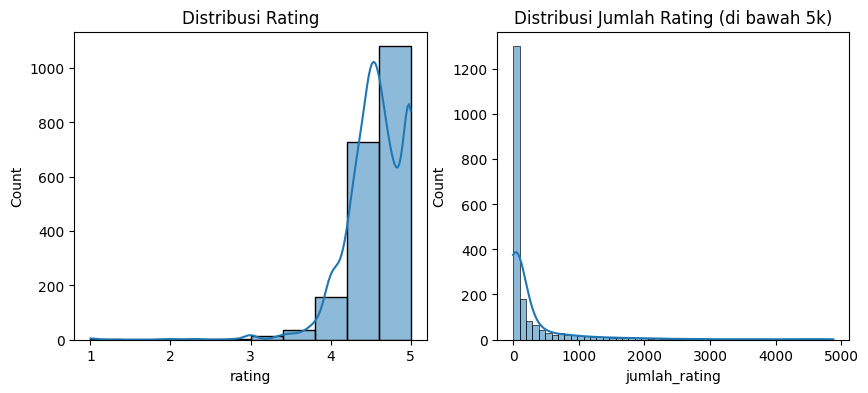

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df_raw['rating'], bins=10, kde=True)
plt.title('Distribusi Rating')

plt.subplot(1, 2, 2)
sns.histplot(df_raw[df_raw['jumlah_rating'] < 5000]['jumlah_rating'], bins=50, kde=True)
plt.title('Distribusi Jumlah Rating (di bawah 5k)')
plt.show()

# TAHAP 3: DATA PREPARATION (PERSIAPAN DATA)

## Pembersihan dan Filtering

In [12]:
df = df_raw.dropna(subset=['rating', 'jumlah_rating', 'latitude', 'longitude', 'kategori', 'preferensi', 'kecamatan'])
print(f"Baris setelah menghapus NaN (data kosong): {len(df)}")

Baris setelah menghapus NaN (data kosong): 2020


### Menerapkan filter kualitas (sesuai Business Understanding)

In [24]:
# Kita hanya ingin merekomendasikan tempat yang "layak"
RATING_THRESHOLD = 4.0  # Minimal rating 4.5
REVIEWS_THRESHOLD = 100 # Minimal 100 ulasan

df_filtered = df[(df['rating'] >= RATING_THRESHOLD) & (df['jumlah_rating'] >= REVIEWS_THRESHOLD)].copy()
print(f"Baris setelah filter kualitas (Rating >= {RATING_THRESHOLD} & Ulasan >= {REVIEWS_THRESHOLD}): {len(df_filtered)}")

Baris setelah filter kualitas (Rating >= 4.0 & Ulasan >= 100): 697


In [25]:
# Reset index agar konsisten
df_filtered.reset_index(drop=True, inplace=True)

In [26]:
# Membuat dataframe terpisah untuk 'lookup' (pencarian)
# Ini berisi info yang tidak kita pakai untuk training, tapi penting untuk hasil akhir
df_lookup = df_filtered[['nama_tempat_wisata', 'link', 'latitude', 'longitude', 'rating', 'jumlah_rating', 'kategori']]

## Rekayasa Fitur (Feature Engineering)

In [27]:
# Mendefinisikan fitur untuk autoencoder (sesuai Data Understanding)
# Kita ingin "kesamaan" berdasarkan: rating, jumlah ulasan, kategori, preferensi, dan kecamatan
numerical_features = ['rating', 'jumlah_rating']
categorical_features = ['kategori', 'preferensi', 'kecamatan']

# Membuat transformer
# 1. Normalisasi fitur numerik (MinMaxScaler): Scaling 0-1
# 2. Encoding fitur kategorikal (OneHotEncoder)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop' # Abaikan kolom lain
)

# Terapkan preprocessor
preprocessed_data = preprocessor.fit_transform(df_filtered)
print(f"Data berhasil diproses. Dimensi data input untuk model: {preprocessed_data.shape}")

Data berhasil diproses. Dimensi data input untuk model: (697, 54)


# TAHAP 4: MODELING (PEMODELAN)

## Arsitektur Autoencoder

In [32]:
# Tujuannya: Mengkompresi fitur" menjadi 'embedding' (representasi laten)
# Ini adalah unsupervised learning untuk klasterisasi/pencarian kesamaan
input_dim = preprocessed_data.shape[1]
bottleneck_dim = 8  # Dimensi laten (embedding)

# Input layer
input_layer = Input(shape=(input_dim,), name="Input_Layer")
# Encoder (Mengecil)
encoder = Dense(64, activation='relu', name="Encoder_1")(input_layer)
encoder = Dense(32, activation='relu', name="Encoder_2")(encoder)
bottleneck = Dense(bottleneck_dim, activation='relu', name="Bottleneck_Layer")(encoder)
# Decoder (Membesar kembali)
decoder = Dense(32, activation='relu', name="Decoder_1")(bottleneck)
decoder = Dense(64, activation='relu', name="Decoder_2")(decoder)
output_layer = Dense(input_dim, activation='sigmoid', name="Output_Layer")(decoder) # Sigmoid karena input 0-1

# Gabungkan jadi Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=output_layer, name="Autoencoder")
autoencoder.compile(optimizer=Adam(), loss='mse') # Loss = MSE (sesuai rencana)

autoencoder.summary()

Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 54)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_1 (Dense)               │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_2 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Bottleneck_Layer (Dense)        │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_1 (Dense)               │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_2 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 54)             │         3,510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,774 (45.99 KB)

 Trainable params: 11,774 (45.99 KB)

 Non-trainable params: 0 (0.00 B)

## Pelatihan Model

In [33]:
preprocessed_data_dense = preprocessed_data.toarray().astype(np.float32)
history = autoencoder.fit(preprocessed_data_dense, preprocessed_data_dense,
                          epochs=50,
                          batch_size=16,
                          shuffle=True, # Changed to True for better training performance
                          verbose=1)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2205
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0463
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0343
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0209
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198
Epoch 14/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0189
Epoch 15/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0187
Epoch 16/50
44/44 ━

## Menghasilkan Embeddings (Representasi Laten)

In [34]:
# Kita buat model 'encoder' terpisah untuk mendapatkan output bottleneck
encoder_model = Model(inputs=input_layer, outputs=bottleneck, name="Encoder")

In [35]:
# Prediksi untuk mendapatkan embedding dari semua data
place_embeddings = encoder_model.predict(preprocessed_data.toarray().astype(np.float32))
print(f"Berhasil membuat embedding untuk {place_embeddings.shape[0]} tempat. Dimensi: {place_embeddings.shape[1]}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Berhasil membuat embedding untuk 697 tempat. Dimensi: 8


## Menghitung Matriks Kesamaan (Similarity Matrix)

In [36]:
# Menghitung kesamaan antar semua tempat berdasarkan embedding-nya
similarity_matrix = cosine_similarity(place_embeddings)
print(f"Matriks kesamaan berhasil dibuat. Ukuran: {similarity_matrix.shape}")

Matriks kesamaan berhasil dibuat. Ukuran: (697, 697)


# TAHAP 5: EVALUATION (EVALUASI)

## Evaluasi Kuantitatif (Metrik Model)

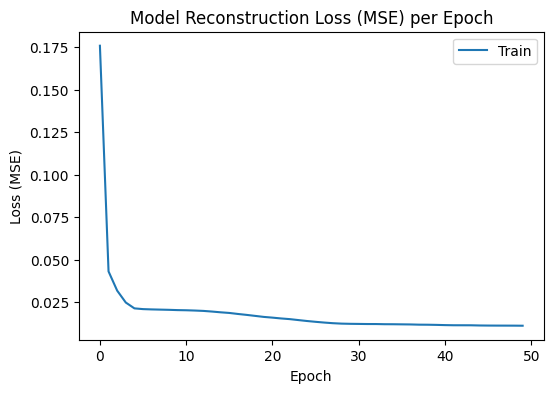

Final Reconstruction Loss (MSE): 0.011023


In [37]:
# Metrik utama untuk autoencoder adalah 'Reconstruction Loss' (MSE)
# plot loss selama training
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.title('Model Reconstruction Loss (MSE) per Epoch')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()
print(f"Final Reconstruction Loss (MSE): {history.history['loss'][-1]:.6f}")

## Fungsi Pembantu (Geospasial)

In [38]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius bumi dalam km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# TAHAP 6: DEPLOYMENT (PENYEBARAN)

Catatan: 'Deployment' dalam konteks ini adalah membuat fungsi siap pakai.

Fungsi ini dapat dipanggil di aplikasi web (cth: Streamlit atau Flask).

## Membuat Fungsi Rekomendasi Final

In [39]:
def get_recommendations_hybrid(input_place_name, user_lat, user_lon, radius_km=10, top_n=5):
    """
    Memberikan rekomendasi hybrid (3 Lapis):
    1. Mencari tempat yang 'mirip' (Content-Based Deep Learning)
    2. Memfilter yang 'dekat' (Geospatial Filter)
    3. Mengurutkan dari yang 'terbaik' (Quality Sort)
    """

    # 1. Cari index dari tempat yang diinput
    try:
        # Gunakan df_lookup yang index-nya sudah di-reset
        place_index = df_lookup[df_lookup['nama_tempat_wisata'] == input_place_name].index[0]
    except IndexError:
        print(f"Error: Tempat '{input_place_name}' tidak ditemukan di database.")
        return pd.DataFrame()

    # 2. Dapatkan skor kesamaan (dari Autoencoder)
    similarity_scores = list(enumerate(similarity_matrix[place_index]))

    # 3. Buat DataFrame dari skor
    df_similar = pd.DataFrame(similarity_scores, columns=['index', 'similarity'])

    # Gabungkan dengan info dari df_lookup (pastikan index cocok)
    df_similar = df_similar.join(df_lookup)

    # 4. Hitung jarak (Geospatial Filter)
    df_similar['distance_km'] = df_similar.apply(
        lambda row: haversine(user_lat, user_lon, row['latitude'], row['longitude']),
        axis=1
    )

    # 5. Terapkan Filter
    # Hapus tempat input itu sendiri dari rekomendasi
    df_final_recs = df_similar[df_similar['index'] != place_index]

    # Filter berdasarkan radius
    df_final_recs = df_final_recs[df_final_recs['distance_km'] <= radius_km]

    # 6. Urutkan berdasarkan Kualitas & Kesamaan (Quality Sort)
    # Ini adalah logika inti:
    # 1. Utamakan kesamaan (similarity)
    # 2. Jika mirip, utamakan rating tertinggi
    # 3. Jika rating sama, utamakan ulasan terbanyak
    df_final_recs = df_final_recs.sort_values(
        by=['similarity', 'rating', 'jumlah_rating'],
        ascending=[False, False, False]
    )

    return df_final_recs.head(top_n)

## Contoh Penggunaan (Kembali ke Evaluasi Kualitatif)

In [40]:
print(" 🚀 PENGUJIAN FUNGSI DEPLOYMENT 🚀 ")

 🚀 PENGUJIAN FUNGSI DEPLOYMENT 🚀 


### CONTOH 1: WISATA BUDAYA

In [41]:
print("\n" + "="*30)
print(" 🚀 CONTOH 1: WISATA BUDAYA 🚀 ")
print("="*30)

input_place = "Taman Budaya Sentul City"
user_location = (-6.58, 106.88) # Lokasi user (misal: dekat Taman Budaya)
search_radius = 20 # Mencari dalam radius 20 km

print(f"\nUser berada di: {user_location}")
# Ambil kategori dari df_lookup
kategori_input_1 = df_lookup.loc[df_lookup['nama_tempat_wisata'] == input_place, 'kategori'].values
if len(kategori_input_1) > 0:
    print(f"User baru saja mengunjungi: {input_place} (Kategori: {kategori_input_1[0]})")
else:
    print(f"User baru saja mengunjungi: {input_place} (Kategori: Tidak Ditemukan)")

print(f"Mencari rekomendasi serupa dalam radius {search_radius} km...")

# Dapatkan rekomendasi
recommendations = get_recommendations_hybrid(input_place, user_location[0], user_location[1], radius_km=search_radius)

if recommendations.empty:
    print("\nMaaf, tidak ditemukan rekomendasi yang mirip dan berdekatan.")
else:
    print("\n--- HASIL REKOMENDASI (BUDAYA) ---")
    for i, row in recommendations.iterrows():
        print(f"  Nama: {row['nama_tempat_wisata']} (Kategori: {row['kategori']})")
        print(f"  Rating: {row['rating']} ({row['jumlah_rating']} ulasan)")
        print(f"  Jarak: {row['distance_km']:.2f} km")
        print(f"  Kesamaan: {row['similarity']:.3f}")
        print(f"  Link: {row['link']}\n")


 🚀 CONTOH 1: WISATA BUDAYA 🚀 

User berada di: (-6.58, 106.88)
User baru saja mengunjungi: Taman Budaya Sentul City (Kategori: Budaya)
Mencari rekomendasi serupa dalam radius 20 km...

--- HASIL REKOMENDASI (BUDAYA) ---
  Nama: Wisata Edukasi TK SD di Bogor (Kategori: Budaya)
  Rating: 4.9 (1615.0 ulasan)
  Jarak: 4.40 km
  Kesamaan: 0.995
  Link: https://www.google.com/maps/place/Wisata+Edukasi+TK+SD+di+Bogor/data=!4m7!3m6!1s0x2e69c6eb1a26803b:0xf7a84ee1b7a1f68b!8m2!3d-6.5757239!4d106.8403557!16s%2Fg%2F11bymykydq!19sChIJO4AmGuvGaS4Ri_aht-FOqPc?authuser=0&hl=id&rclk=1

  Nama: Paintball Sentul (Kategori: Rekreasi)
  Rating: 4.9 (431.0 ulasan)
  Jarak: 2.48 km
  Kesamaan: 0.993
  Link: https://www.google.com/maps/place/Paintball+Sentul/data=!4m7!3m6!1s0x2e69c7028dcfa381:0xc7aa2300e88e8856!8m2!3d-6.5715195!4d106.8592497!16s%2Fg%2F11bwfmgcpq!19sChIJgaPPjQLHaS4RVoiO6AAjqsc?authuser=0&hl=id&rclk=1

  Nama: Garuda Farm Sentul - WISATA EDUKASI ANAK TK DAN SD (Kategori: Rekreasi)
  Rating: 4.

### CONTOH 2: WISATA ALAM

In [42]:
print("\n" + "="*30)
print(" 🚀 CONTOH 2: WISATA ALAM 🚀 ")
print("="*30)

input_place_2 = "Curug Cilember"
user_location_2 = (-6.68, 106.94) # Lokasi user (di Cisarua)
search_radius_2 = 15

print(f"User berada di: {user_location_2}")
kategori_input_2 = df_lookup.loc[df_lookup['nama_tempat_wisata'] == input_place_2, 'kategori'].values
if len(kategori_input_2) > 0:
    print(f"User baru saja mengunjungi: {input_place_2} (Kategori: {kategori_input_2[0]})")
else:
    print(f"User baru saja mengunjungi: {input_place_2} (Kategori: Tidak Ditemukan)")

print(f"Mencari rekomendasi serupa dalam radius {search_radius_2} km...")

recommendations_2 = get_recommendations_hybrid(input_place_2, user_location_2[0], user_location_2[1], radius_km=search_radius_2)

if recommendations_2.empty:
    print("\nMaaf, tidak ditemukan rekomendasi yang mirip dan berdekatan.")
else:
    print("\n--- HASIL REKOMENDASI (ALAM) ---")
    for i, row in recommendations_2.iterrows():
        print(f"  Nama: {row['nama_tempat_wisata']} (Kategori: {row['kategori']})")
        print(f"  Rating: {row['rating']} ({row['jumlah_rating']} ulasan)")
        print(f"  Jarak: {row['distance_km']:.2f} km")
        print(f"  Kesamaan: {row['similarity']:.3f}")
        print(f"  Link: {row['link']}\n")


 🚀 CONTOH 2: WISATA ALAM 🚀 
User berada di: (-6.68, 106.94)
User baru saja mengunjungi: Curug Cilember (Kategori: Alam)
Mencari rekomendasi serupa dalam radius 15 km...

--- HASIL REKOMENDASI (ALAM) ---
  Nama: NICOLE'S RIVER PARK (Kategori: Alam)
  Rating: 4.5 (4540.0 ulasan)
  Jarak: 5.81 km
  Kesamaan: 1.000
  Link: https://www.google.com/maps/place/NICOLE%27S+RIVER+PARK/data=!4m7!3m6!1s0x2e69c94ce798c59f:0xcc5f68b129fb50f1!8m2!3d-6.6500814!4d106.8968945!16s%2Fg%2F11s1ttfp6t!19sChIJn8WY50zJaS4R8VD7KbFoX8w?authuser=0&hl=id&rclk=1

  Nama: Perkebunan Teh Puncak (Kategori: Alam)
  Rating: 4.5 (198.0 ulasan)
  Jarak: 6.42 km
  Kesamaan: 1.000
  Link: https://www.google.com/maps/place/Perkebunan+Teh+Puncak/data=!4m7!3m6!1s0x2e69b6a7cc4208fd:0xce1047d0ed2db577!8m2!3d-6.7015573!4d106.9939486!16s%2Fg%2F11cjhr_gp5!19sChIJ_QhCzKe2aS4Rd7Ut7dBHEM4?authuser=0&hl=id&rclk=1

  Nama: Taman Kecubung (Kategori: Alam)
  Rating: 4.5 (190.0 ulasan)
  Jarak: 5.24 km
  Kesamaan: 1.000
  Link: https://www